# Lego Block Classification F1 score=99.53%

## Importar modulos necesarios

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [2]:
# # ESTE CODIGO SOLO SE HABILITA SI SE VA A EJECUTAR EN
# # EL ENTORNO GOOGLE-COLAB Y NECESITAMOS ELIMINAR UNA CARPETA NO VACIA
# # EN NUESTRO CASO SIEMPRE SE CREA UNA CARPETA INNECESARIA, POR TANTO PROCEDEMOS A ELIMINARLA

# import shutil

# # Ruta de la carpeta a eliminar
# folder_path = '/content/sample_data'

# # Eliminar la carpeta y su contenido
# shutil.rmtree(folder_path)

# # NOTA: Subir el archivo LEGO_brick_images_v1.zip a la carpeta '/content' para poder continuar

# Ruta al archivo ZIP del dataset
zip_path = '/content/LEGO_brick_images_v1.zip'

# Ruta donde vamos a descomprimir el archivo
extract_path = '/content'

# Creamos la carpeta destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Listar los archivos descomprimidos
extracted_files = os.listdir(extract_path)
print("Archivos descomprimidos:")
print(extracted_files)

Archivos descomprimidos:
['.config', 'LEGO_brick_images_v1', 'LEGO_brick_images_v1.zip']


## Concepto de Callback Personalizado
Este "callback" es una herramienta que ajusta automáticamente la tasa de aprendizaje mientras entrena un modelo. Vigila cómo varía la pérdida de validación y guarda los mejores valores que encuentra. Si la pérdida de validación disminuye, conserva esos valores; si aumenta, vuelve a los mejores valores guardados, reduce la tasa de aprendizaje y continúa entrenando. Al final, garantiza que el modelo tenga los mejores resultados obtenidos durante el entrenamiento. Además, ofrece la opción de detener el entrenamiento o cambiar manualmente la tasa de aprendizaje si es necesario. Es útil para saber cuándo detener el entrenamiento o ajustar la tasa de aprendizaje para mejorar los resultados.


## Definir una función para imprimir texto en colores específicos de primer plano (foreground) y fondo (background) en formato RGB.
Añade un toque especial a tu salida impresa con esta función. La forma de llamar a la función es: print_in_color(txt_msg, fore_tupple, back_tupple) donde:

- 'txt_msg' es la cadena de texto que se imprimirá.
- 'fore_tuple' es una tupla en formato (r, g, b) que especifica el color de primer plano del texto.
- 'back_tuple' es una tupla en formato (r, g, b) que especifica el color de fondo del texto.

In [3]:
def print_in_color(txt_msg,fore_tupple=(0,200,0),back_tupple=(56,56,56)):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

msg='Mensaje de prueba: ANGEL LOZANO LOPEZ'
print_in_color(msg)

Mensaje de prueba: ANGEL LOZANO LOPEZ



## Define una función que grafique el conteo de valores para una columna en un dataframe.

Esta función, llamada plot_label_count, genera un gráfico de barras para mostrar el recuento de valores en una columna específica de un DataFrame. Aquí está el desglose de lo que hace cada paso:
- 'df' es el DataFrame que contiene los datos.
- 'column' es el nombre de la columna para la cual queremos contar y visualizar los valores.

Dentro de la función:
- 'vcounts' calcula el recuento de ocurrencias de cada valor en la columna especificada.
- 'labels' y 'values' obtienen las etiquetas (valores únicos) y sus recuentos a partir de vcounts.

Luego, se configura el gráfico:
- Se establece el tamaño de la figura utilizando plt.figure para asegurarse de que sea lo suficientemente grande para mostrar los datos de manera legible.
- Se configura el estilo de la fuente para el título y los ejes x e y con el diccionario form.
- plt.bar crea el gráfico de barras con las etiquetas en el eje x y los valores en el eje y.
- plt.title, plt.xlabel, y plt.ylabel configuran los títulos y etiquetas de los ejes x e y.
Finalmente, plt.show() muestra el gráfico de barras en la salida.

En resumen, esta función toma un DataFrame y una columna específica, cuenta la frecuencia de cada valor en esa columna y crea un gráfico de barras que muestra la cantidad de veces que aparece cada valor en esa columna. Es útil para visualizar la distribución de los valores en una columna dada.

In [4]:
def plot_label_count (df, column):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    plt.figure(figsize=(20,5))
    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    plt.bar(labels, values)
    plt.title('Images per label', fontsize= 24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Labels", fontdict=form)
    plt.ylabel('Number of Images', fontdict=form)
    plt.show()

## Leer los datos de entrada y crear DataFrames para entrenamiento, prueba y validación.
Esta función llamada make_dataframes se encarga de generar marcos de datos (DataFrames) a partir de directorios que contienen imágenes. Los directorios de entrenamiento, prueba y validación son proporcionados como argumentos a la función.

Aquí hay un resumen de lo que hace la función:

1. Configuración inicial:
- Comprueba si se proporcionan directorios de prueba y/o validación. Define una lista dirlist y una lista names basándose en la presencia o ausencia de estos directorios.

2. Iteración sobre los directorios de cada conjunto:
- Lee las imágenes en los directorios correspondientes, procesando cada imagen.
- Crea una lista de rutas de archivo (filepaths) y una lista de etiquetas (labels) para cada imagen.
- Crea una serie para las rutas de archivo y otra para las etiquetas, y las combina en un DataFrame (df) para cada conjunto de datos (train, test, valid).

3. División de los datos:
- Si no se proporcionan directorios de prueba y/o validación separados, se divide el conjunto de entrenamiento en conjuntos de entrenamiento, prueba y validación utilizando train_test_split.
- Si solo falta un conjunto de datos (ya sea prueba o validación), se dividen los datos restantes en conjuntos de entrenamiento y el faltante se asigna a prueba o validación.
- Calcula la cantidad de clases, las muestra y proporciona detalles sobre las dimensiones promedio de las imágenes en el conjunto de entrenamiento.

4. Información final y retorno:
-Imprime información sobre las clases, el número de archivos por clase y la longitud de los conjuntos de datos de entrenamiento, prueba y validación.
-Calcula el promedio de alto y ancho de las imágenes y su relación de aspecto (alto/ancho).
-Retorna los DataFrames train_df, test_df, valid_df, una lista de clases classes y el número total de clases class_count.

El código al final muestra cómo se utiliza la función make_dataframes para generar DataFrames a partir de directorios que contienen imágenes de ladrillos LEGO.

In [5]:
def make_dataframes(train_dir,test_dir, val_dir):
    bad_images=[]
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test']
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )
        for klass in classlist:
            classpath=os.path.join(d, klass)
            flist=sorted(os.listdir(classpath))
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=plt.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(klass[:25])
                except:
                    print (fpath, ' is an invalid image file')
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None:
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None:
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else : # create a  validation dataframe
                pdf=df
                train_df,valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=100, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'/content/LEGO_brick_images_v1' # HABILITAR EN GOOGLE-COLAB
# train_dir = r'C:\PYTHON\PRACTICAS\09 Lego Bricks\archive\LEGO_brick_images_v1' # HABILITAR EN MODO LOCAL
val_dir= None # if there is no validation directory set val_dir = None, a valid_df dataframe will be created from train_df
test_dir= None # if there is no test directory set test_dir = None, a test_df dataframe will be created from train_df

train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir,test_dir, val_dir)

train -6632 Technic Lever 3M    : 100%|█████████████████████████████████████████████████████| 400/400 [00:00<00:00, 940.74files/s]


number of classes in processed dataset=  16
the maximum files in any class in train_df is  320   the minimum files in any class in train_df is  303
train_df length:  5103   test_df length:  638   valid_df length:  638
average image height=  200   average image width=  200  aspect ratio h/w=  1.0


## Veamos la cantidad de muestras de imágenes para cada etiqueta.
Este fragmento de código tiene una condición que verifica si el número de etiquetas únicas en el conjunto de datos de entrenamiento (train_df) es menor que 20. Si esa condición se cumple, se llama a la función plot_label_count para generar un gráfico de barras que muestra el recuento de muestras de imágenes para cada etiqueta presente en el conjunto de datos de entrenamiento.

Si hubiera más de 20 etiquetas únicas, el gráfico resultante podria ser difícil de entender, por lo que este bloque de código evita generar el gráfico en tales casos.

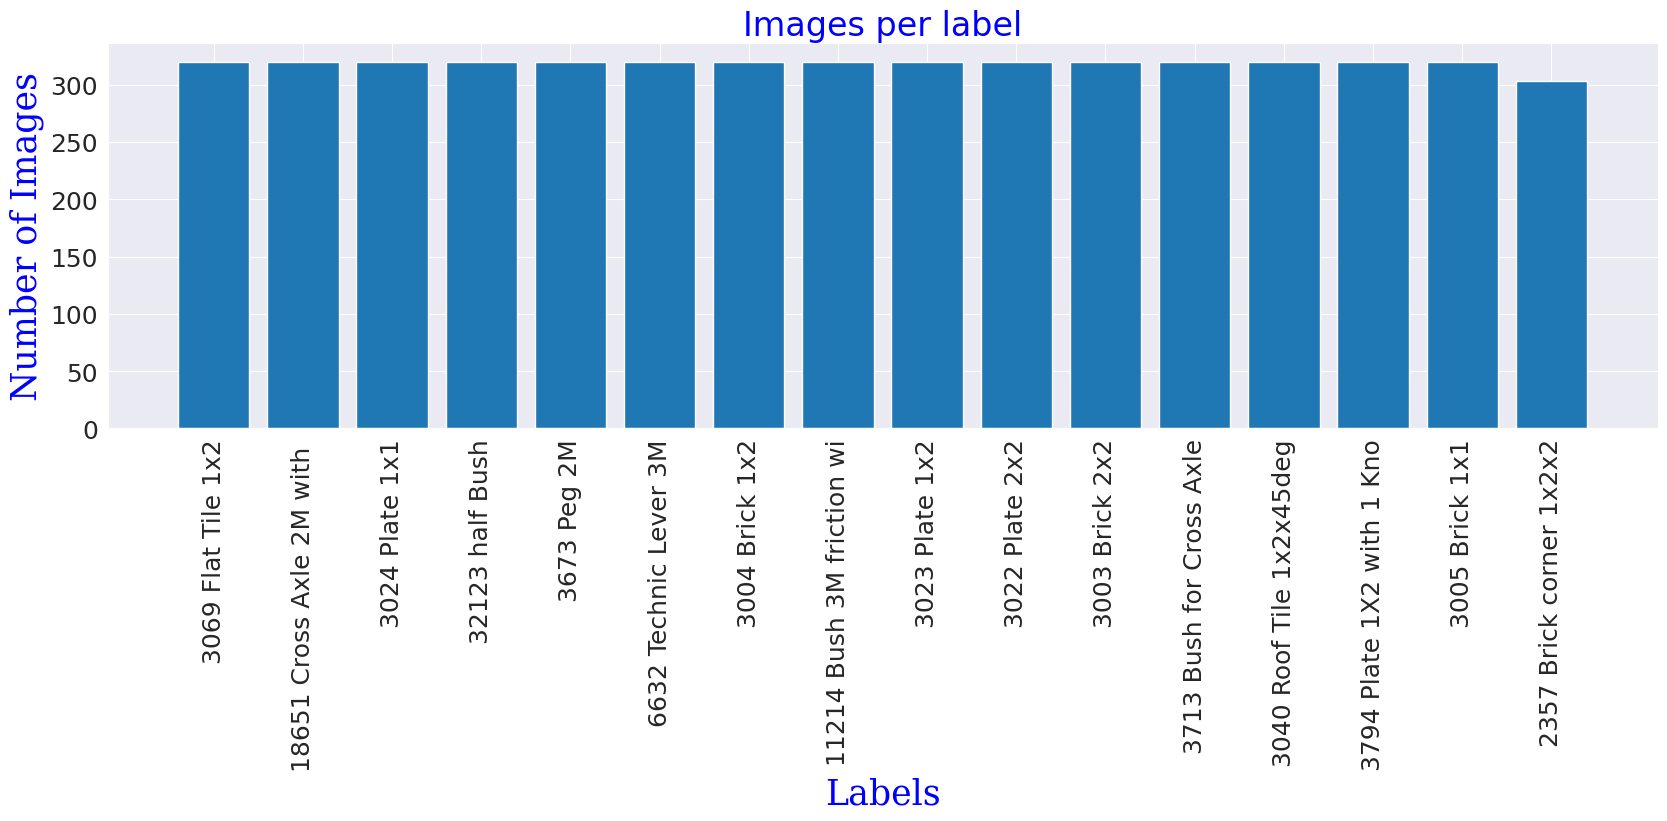

In [6]:
if len(train_df['labels'].unique())<20: # Over 20 labels the plot is to hard to understand
    plot_label_count (train_df, 'labels')

## Recortar train_df para que ninguna clase tenga más de 'max_samples' imágenes.
Este fragmento de código define una función llamada trim que ajusta un DataFrame para asegurarse de que ninguna clase tenga más de un número máximo (max_samples) de imágenes. Aquí está el desglose de lo que hace:

1. Preparación inicial:
- Hace una copia del DataFrame original (df) para realizar modificaciones sin alterar el original.
- Identifica las clases únicas presentes en la columna especificada (column) del DataFrame.
- Muestra la longitud inicial del DataFrame y la cantidad de clases presentes.

2. Iteración sobre grupos de clases:
- Agrupa el DataFrame por la columna de clases (column).
- Recorre cada etiqueta única en las clases presentes en el DataFrame original.
- Verifica el recuento de muestras de cada clase y realiza ajustes si es necesario:
    - Si el recuento es mayor que max_samples, selecciona aleatoriamente max_samples muestras de esa clase y las agrega al nuevo       DataFrame trimmed_df.
    - Si el recuento está entre min_samples y max_samples, mantiene todas las muestras de esa clase en el DataFrame resultante.
    - Actualiza y muestra la cantidad máxima y mínima de muestras en cualquier clase después del ajuste.

3. Información final y retorno:
- Muestra la longitud final del DataFrame ajustado (trimmed_df) y la cantidad de clases presentes después del ajuste.
- Retorna el DataFrame ajustado, las clases presentes y el número total de clases.

El código al final muestra cómo se utiliza esta función trim para asegurar que ninguna clase en el conjunto de datos de entrenamiento (train_df) tenga más de 300 imágenes (max_samples) y al menos 300 imágenes (min_samples).

In [7]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('El DataFrame inicial tiene una longitud de ',length, ' con ', class_count, ' clases')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('Después del recorte, el máximo de muestras en cualquier clase es ahora ',max_samples, ' y el mínimo de muestras en cualquier clase es ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('Ahora el DataFrame recortado tiene una longitud de ',length, ' con ', class_count, ' clases')
    return trimmed_df, classes, class_count

max_samples=300
min_samples=300
column='labels'
train_df, classes, class_count = trim(train_df, max_samples, min_samples, column)

El DataFrame inicial tiene una longitud de  5103  con  16  clases
Después del recorte, el máximo de muestras en cualquier clase es ahora  300  y el mínimo de muestras en cualquier clase es  300
Ahora el DataFrame recortado tiene una longitud de  4800  con  16  clases


## Ampliar filas de train_df con imágenes aumentadas para que cada clase tenga n muestras.
La función trim equilibró el train_df a 300 imágenes por clase, por lo que esta función no se usa en este cuaderno.

In [8]:
def balance(df, n,column, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

## Mostrar imágenes de train_df por etiqueta después de equilibrar el conjunto de datos
La línea de código plot_label_count(train_df, 'labels') llama a la función plot_label_count para generar un gráfico de barras que muestra la cantidad de imágenes por etiqueta en el DataFrame de entrenamiento, utilizando la columna 'labels'. Esto permite visualizar la distribución de las imágenes entre las diferentes etiquetas después del proceso de equilibrio del conjunto de datos.

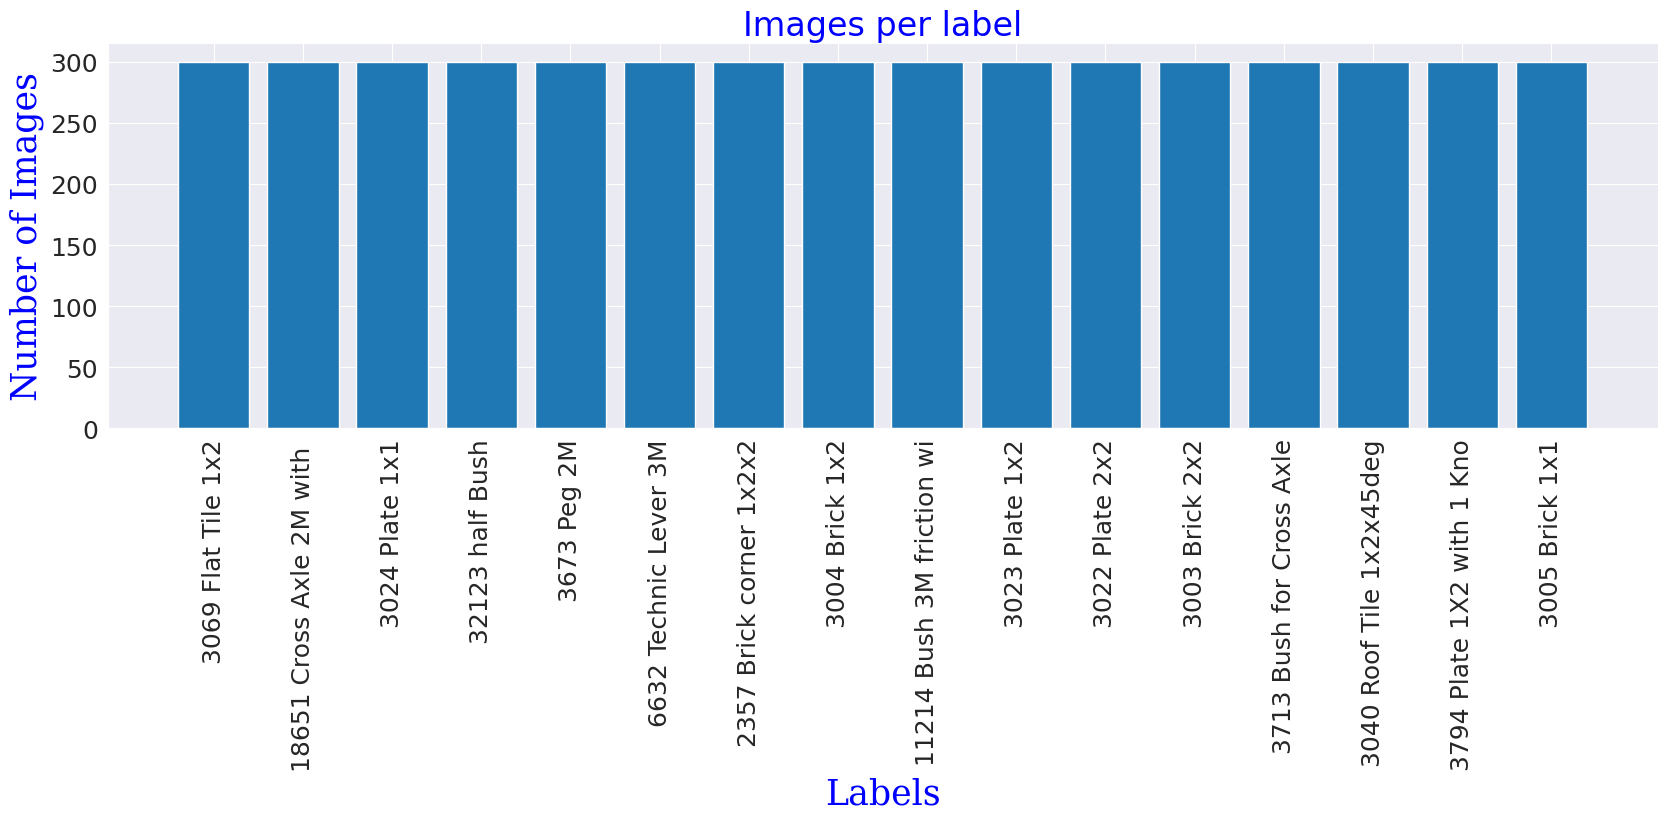

In [ ]:
plot_label_count(train_df, 'labels')

## Crear train_gen, test_gen, final_test_gen y valid_gen
Este código está diseñado para crear generadores de imágenes para entrenamiento, validación y prueba, basados en los DataFrames proporcionados y otros parámetros dados. Aquí está la explicación de lo que hace cada parte del código:

1. **Definición de la función `make_gens`**:
   - Recibe varios parámetros: `batch_size` (tamaño del lote), `ycol` (columna de etiquetas), DataFrames de entrenamiento, prueba y validación (`train_df`, `test_df`, `valid_df`) y el tamaño de la imagen (`img_size`).

2. **Generadores de imágenes**:
   - `trgen=ImageDataGenerator(horizontal_flip=True)`: Crea un generador de imágenes para entrenamiento con una posible transformación de volteo horizontal.
   - `t_and_v_gen=ImageDataGenerator()`: Crea otro generador de imágenes para uso en validación y prueba, sin transformaciones específicas.

3. **Flujo de datos desde DataFrames**:
   - Se crea un flujo de datos (`flow_from_dataframe`) para el conjunto de entrenamiento (`train_df`), validación (`valid_df`) y prueba (`test_df`) utilizando los generadores de imágenes previamente configurados.
   - Los flujos se establecen a partir de los DataFrames proporcionados, especificando la columna de rutas de archivo (`x_col='filepaths'`), la columna de etiquetas (`y_col=ycol`), el tamaño de la imagen (`target_size=img_size`), el modo de clase (`class_mode='categorical'`), el modo de color (`color_mode='rgb'`), y otras configuraciones.

4. **Generador de prueba personalizado**:
   - Para el generador de pruebas (`test_gen`), se calcula un tamaño de lote (`test_batch_size`) y pasos de prueba (`test_steps`) de manera que el producto de ambos sea igual al número total de muestras en el conjunto de prueba.
   - Se asegura que cada muestra en el conjunto de pruebas se procese exactamente una vez.

5. **Información obtenida y devolución**:
   - Se extrae información importante de los generadores creados, como las clases, los índices de clase, el recuento de clases y las etiquetas.
   - Se muestra información relevante, como el tamaño del lote de prueba, los pasos de prueba y el número de clases.
   - La función devuelve los generadores de entrenamiento, prueba y validación, junto con el número de pasos de prueba.

En resumen, esta función crea y configura generadores de imágenes a partir de DataFrames específicos, listos para ser utilizados en entrenamiento, validación y pruebas de modelos de aprendizaje automático.


In [9]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # Imprime sobre la misma línea.
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # Imprime sobre la misma línea.
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # Para test_gen, queremos calcular el tamaño del lote y los pasos de prueba de manera que
    # el tamaño_del_lote x pasos_de_prueba = número de muestras en el conjunto de prueba.
    # Esto asegura que pasemos por todas las muestras en el conjunto de prueba exactamente una vez.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # Del generador podemos obtener información que necesitaremos más tarde.
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

Este bloque de código establece un tamaño de imagen más pequeño para reducir el tiempo de entrenamiento aunque posiblemente
disminuya el puntaje F1. Luego, establece el tamaño del lote (batch_size) en 30 y renombra la columna de etiquetas (ycol) como 'labels'. Posteriormente, llama a la función make_gens para crear generadores de imágenes de entrenamiento, prueba y validación utilizando estos parámetros y los DataFrames proporcionados (train_df, test_df, valid_df) con el tamaño de imagen especificado (img_size).

In [10]:
img_size=(128,128) # Utiliza un tamaño de imagen más pequeño para reducir el tiempo de entrenamiento pero puede disminuir el puntaje F1
batch_size=30  # Tamaño del lote para el procesamiento por lotes durante el entrenamiento
ycol='labels'  # Nombre de la columna que contiene las etiquetas en los DataFrames

# Crear generadores de imágenes para entrenamiento, prueba y validación utilizando la función previamente definida.
# La función make_gens toma el tamaño del lote, la columna de etiquetas y los DataFrames de entrenamiento, prueba y validación.
# img_size es el tamaño de la imagen que se utilizará en los generadores.
train_gen, test_gen, valid_gen, test_steps = make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 4800 validated image filenames belonging to 16 classes.
Found 638 validated image filenames belonging to 16 classes.
Found 638 validated image filenames belonging to 16 classes.
test batch size:  58   test steps:  11  number of classes :  16


## Crear una función para mostrar ejemplos de imágenes de entrenamiento.
Este bloque de código define una función llamada `show_image_samples` diseñada para visualizar ejemplos de imágenes de entrenamiento:

- `gen` se refiere a un generador de imágenes (posiblemente el generador de entrenamiento).
- Dentro de la función, se captura un conjunto de muestras (`images`, `labels`) del generador usando la función `next()`.
- Se establece una disposición visual para mostrar múltiples imágenes en una sola figura usando Matplotlib.
- Se verifica la longitud de las etiquetas para limitar la visualización a un máximo de 25 imágenes.
- Para cada imagen en el conjunto de datos, se muestra la imagen, se identifica la etiqueta correspondiente y se muestra como título sobre la imagen con un formato específico de tamaño y color.

Finalmente, el fragmento de código llama a la función `show_image_samples`, pasando como argumento el generador de entrenamiento `train_gen`, lo que mostrará una representación visual de las imágenes de entrenamiento junto con sus respectivas etiquetas.


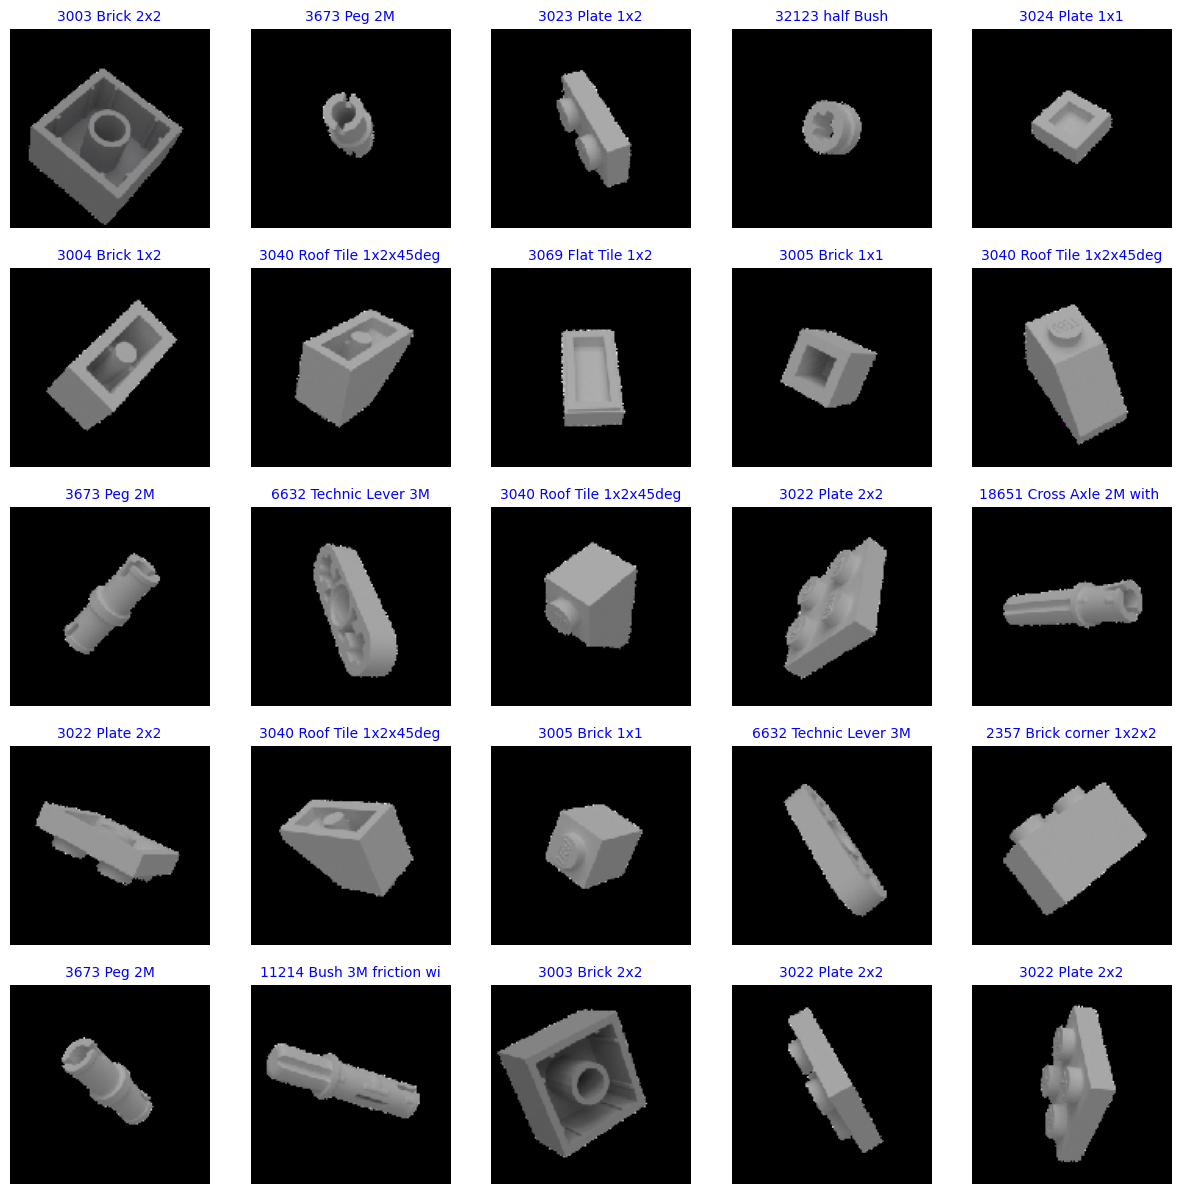

In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=10)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

## Crear una función para calcular la métrica de puntuación F1.
La función `F1_score` calcula la métrica de puntuación F1. Esta función utiliza las siguientes fórmulas y operaciones:

- `true_positives`: Calcula la suma de los verdaderos positivos al redondear y limitar los valores entre 0 y 1.
- `possible_positives`: Calcula la suma de los positivos posibles al redondear y limitar los valores de `y_true` entre 0 y 1.
- `predicted_positives`: Calcula la suma de los positivos predichos al redondear y limitar los valores de `y_pred` entre 0 y 1.
- `precision`: Calcula la precisión dividiendo los verdaderos positivos entre la suma de los positivos predichos, considerando un valor de suavizado (`K.epsilon()`).
- `recall`: Calcula la recuperación dividiendo los verdaderos positivos entre la suma de los positivos posibles, considerando un valor de suavizado (`K.epsilon()`).
- `f1_val`: Calcula el valor de F1 utilizando la fórmula estándar de F1 a partir de la precisión y la recuperación.

Finalmente, la función devuelve el valor de la puntuación F1 calculado.

In [12]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Crear un modelo utilizando transfer learning con EfficientNetB3.
NOTA: Los expertos aconsejan que inicialmente se haga que el modelo base no sea entrenable al realizar transfer learning. Luego, entrenar durante un cierto número de épocas y luego ajusta finamente el modelo haciendo que el modelo base sea entrenable y ejecutando más épocas.
El autor de este cuaderno ha encontrado que esto es INCORRECTO.

Hacer que el modelo base sea entrenable desde el principio conduce a una convergencia más rápida y a una pérdida de validación más baja para el mismo número total de épocas.
Asegúrate de inicializar el modelo de transferencia con pesos de ImageNet.

Este código crea un modelo utilizando la arquitectura EfficientNet, permitiendo elegir entre distintas variantes como B0, B3, B5 o B7. La selección se hace mediante el parámetro mod_num. Este modelo se inicia con pesos preentrenados en ImageNet para la capa convolucional. Además, se agrega una capa densa con regularización L1 y L2, seguida por una capa de abandono (Dropout). Finalmente, se compila el modelo usando el optimizador Adamax con una tasa de aprendizaje inicial dada por lr, una pérdida de entropía cruzada categórica y métricas de precisión y F1.

El modelo generado es una red neuronal convolucional con capas de procesamiento de imágenes y capas densas para la clasificación, utilizando la potente arquitectura EfficientNet como base preentrenada.

In [13]:
def make_model(img_size, lr, mod_num=3):
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B5 model'

    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'

    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score])
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr)

43941136/43941136 [==============================] - 2s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



## Crear un callback personalizado de Keras para continuar y, opcionalmente, establecer la tasa de aprendizaje o detener el entrenamiento.
Este fragmento de código define una clase de Callback llamada "LR_ASK" para usar durante el entrenamiento de un modelo en Keras. Funciona de la siguiente forma:
- Se inicializa con parámetros como el modelo, número de épocas, número de épocas para preguntar, entre otros.
- Durante el entrenamiento, se ejecutan diferentes métodos de la clase. Al inicio, se establecen condiciones y se muestra información sobre el proceso de entrenamiento al usuario.
- En cada final de época, se registra la métrica de pérdida de validación y se compara con el mejor valor hasta el momento.
- Si la pérdida de validación disminuye, se actualizan los mejores pesos del modelo.
- Si la pérdida de validación aumenta, se ajusta automáticamente la tasa de aprendizaje si se habilita la opción "dwell".
- También, el usuario es consultado en momentos específicos durante el entrenamiento para decidir si detener o continuar por más épocas y si se desea cambiar la tasa de aprendizaje.

Este Callback ofrece la capacidad de interactuar durante el entrenamiento, permitiendo pausar, continuar o ajustar la tasa de aprendizaje según el rendimiento del modelo y las preferencias del usuario.

In [14]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to'
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss
            pimprov=(deltav/self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    coment='User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

## Instanciar devolución de llamada personalizada
Este código establece un número total de épocas de entrenamiento (epochs) y define en qué época específica se detendrá momentáneamente el entrenamiento para preguntar al usuario si desea continuar o detenerlo (ask_epoch).

La variable ask instancia el callback personalizado LR_ASK que se utilizará durante el entrenamiento del modelo. Este callback se almacena en una lista  llamada 'callbacks' que se pasará como argumento al método de ajuste (fit) del modelo. La función de este callback es detener temporalmente el entrenamiento en la época especificada y preguntar al usuario si desea continuar entrenando o detenerlo por completo.

In [15]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

## Entrenando el modelo
Contrario a lo que se suele decir, es MEJOR hacer el modelo base entrenable desde el principio si se está realizando transfer learning. El modelo convergerá más rápido y tendrá una pérdida de validación más baja. Asegúrate de inicializar el modelo de transferencia con pesos de ImageNet.
Se han realizado numerosas pruebas ejecutándolo de ambas maneras y siempre hemos encontrado que esto es cierto.

Este fragmento de código usa el método fit() para entrenar un modelo. Aquí hay una descripción paso a paso:
- `model.fit()`: Este método entrena el modelo neuronal.
- `x=train_gen`: Los datos de entrenamiento provienen del generador `train_gen`, que contiene las imágenes de entrenamiento y sus etiquetas.
- `epochs=epochs`: Define el número de épocas para entrenar el modelo.
- `verbose=1`: Muestra información detallada durante el entrenamiento en cada época.
- `callbacks=callbacks`: Utiliza callbacks para ejecutar operaciones personalizadas durante el entrenamiento.
- `validation_data=valid_gen`: Utiliza el generador `valid_gen` para la validación del modelo.
- `validation_steps=None`: Número de pasos por época de validación. Si se establece en `None`, utiliza el tamaño del conjunto de validación.
- `shuffle=False`: No realiza mezcla aleatoria de los datos antes de cada época.
- `initial_epoch=0`: Define la época inicial para comenzar el entrenamiento.

En resumen, este código realiza el entrenamiento de un modelo utilizando generadores de datos para los conjuntos de entrenamiento y validación, y emplea callbacks para ejecutar acciones específicas durante el entrenamiento en cada época.

In [16]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                  validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
160/160 [==============================] - ETA: 0s - loss: 7.7121 - accuracy: 0.6881 - F1_score: 0.6681
 validation loss of  6.1610 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

160/160 [==============================] - 100s 216ms/step - loss: 7.7121 - accuracy: 0.6881 - F1_score: 0.6681 - val_loss: 6.1610 - val_accuracy: 0.8260 - val_F1_score: 0.8089
Epoch 2/40
160/160 [==============================] - ETA: 0s - loss: 5.0360 - accuracy: 0.9173 - F1_score: 0.9104
 validation loss of  4.1343 is 32.8957 % below lowest loss, saving weights from epoch 2   as best weights

160/160 [==============================] - 30s 186ms/step - loss: 5.0360 - accuracy: 0.9173 - F1_score: 0.9104 - val_loss: 4.1343 - val_accuracy: 0.9545 - 

## Definir una función para graficar los datos de entrenamiento
Este fragmento de código define una función para graficar datos de entrenamiento y validación de un modelo. Extrae la información de precisión, pérdida y puntaje F1 del historial del entrenamiento y crea gráficos para visualizar la pérdida y precisión del entrenamiento versus la validación en función de las épocas. Estos gráficos muestran cómo cambian la pérdida, la precisión y el puntaje F1 a lo largo del entrenamiento y la validación del modelo. Además, resalta el mejor desempeño tanto en la pérdida como en la precisión, indicando las épocas correspondientes donde se lograron estos valores máximos o mínimos. Finalmente, muestra tres subgráficos que representan la pérdida, la precisión y el puntaje F1 respectivamente.

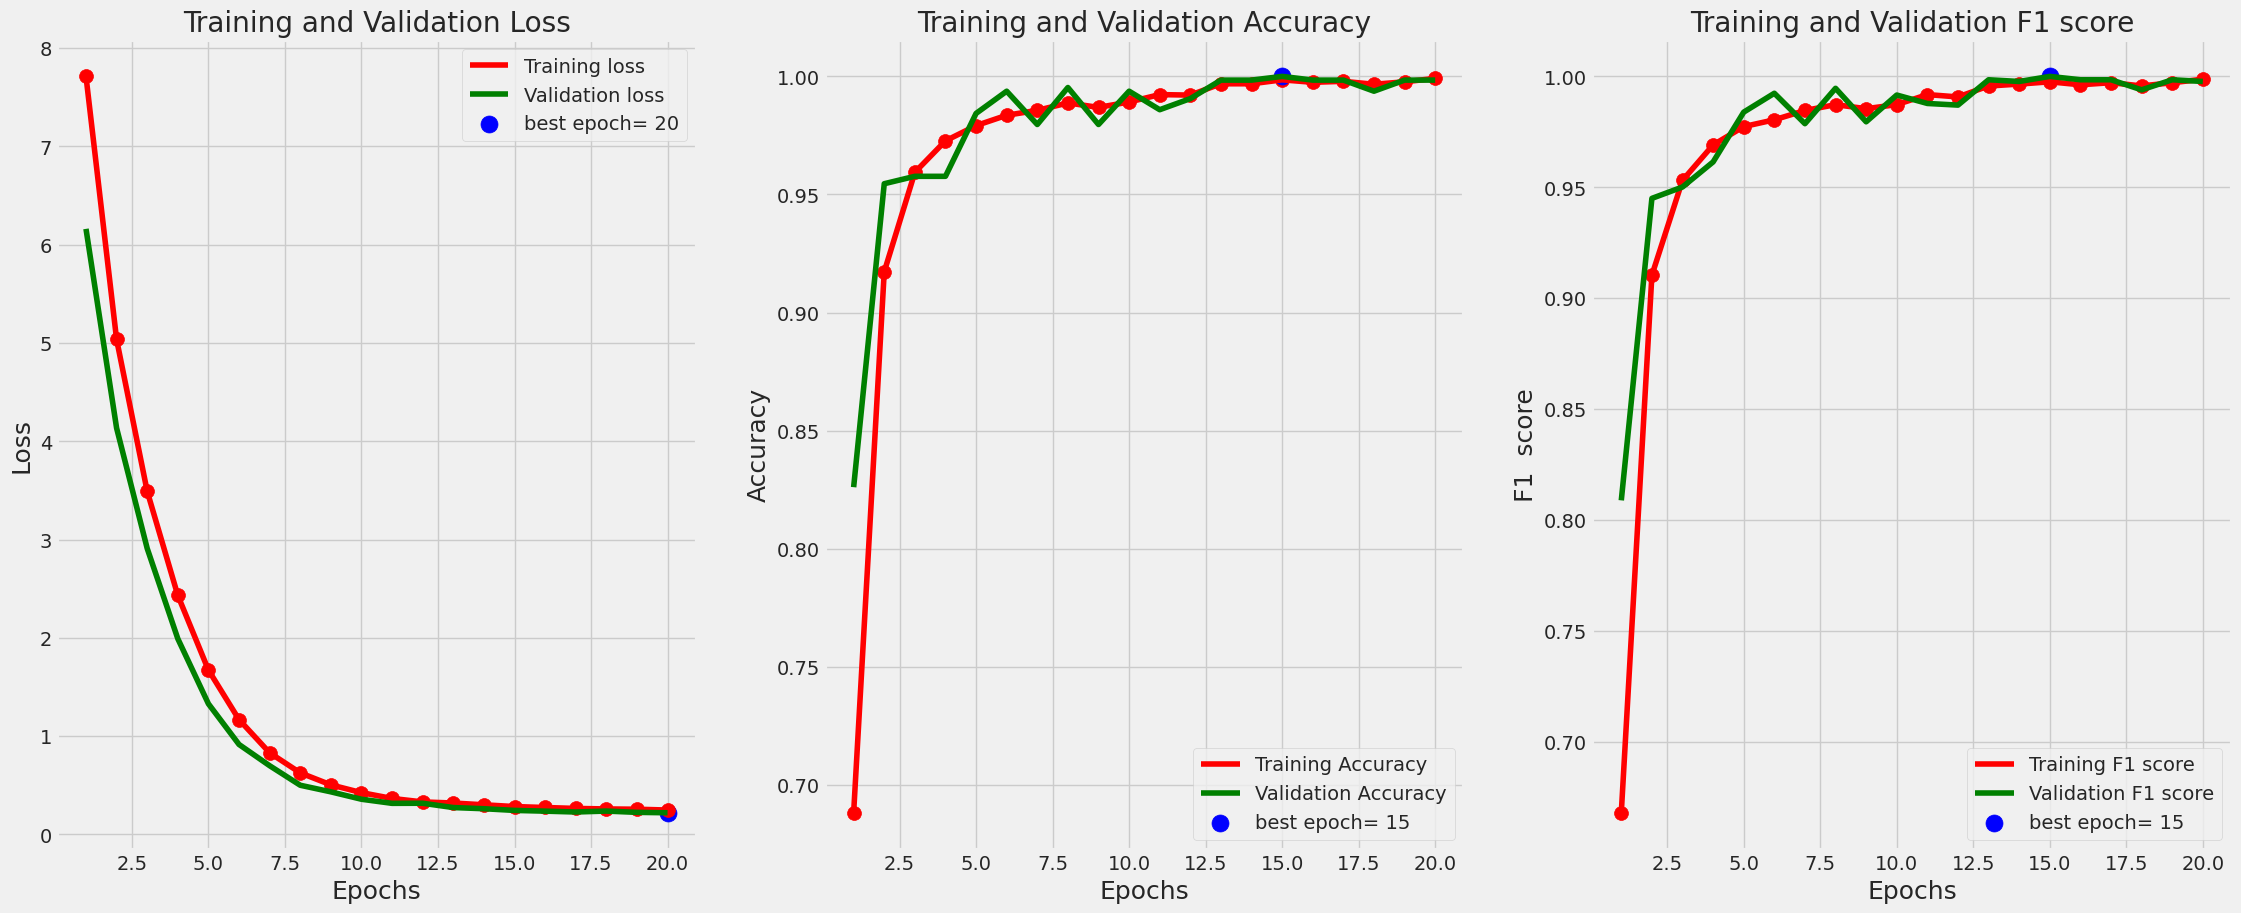

In [17]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss')
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()

    plt.tight_layout
    plt.show()
    return

tr_plot(history)

## Realizar predicciones en el conjunto de pruebas
Definir una función que recibe un generador de pruebas y genera predicciones en el conjunto de pruebas, incluyendo una matriz de confusión y un reporte de clasificación.

11/11 [==============================] - 10s 258ms/step
there were 0 errors in 638 tests for an accuracy of 100.00



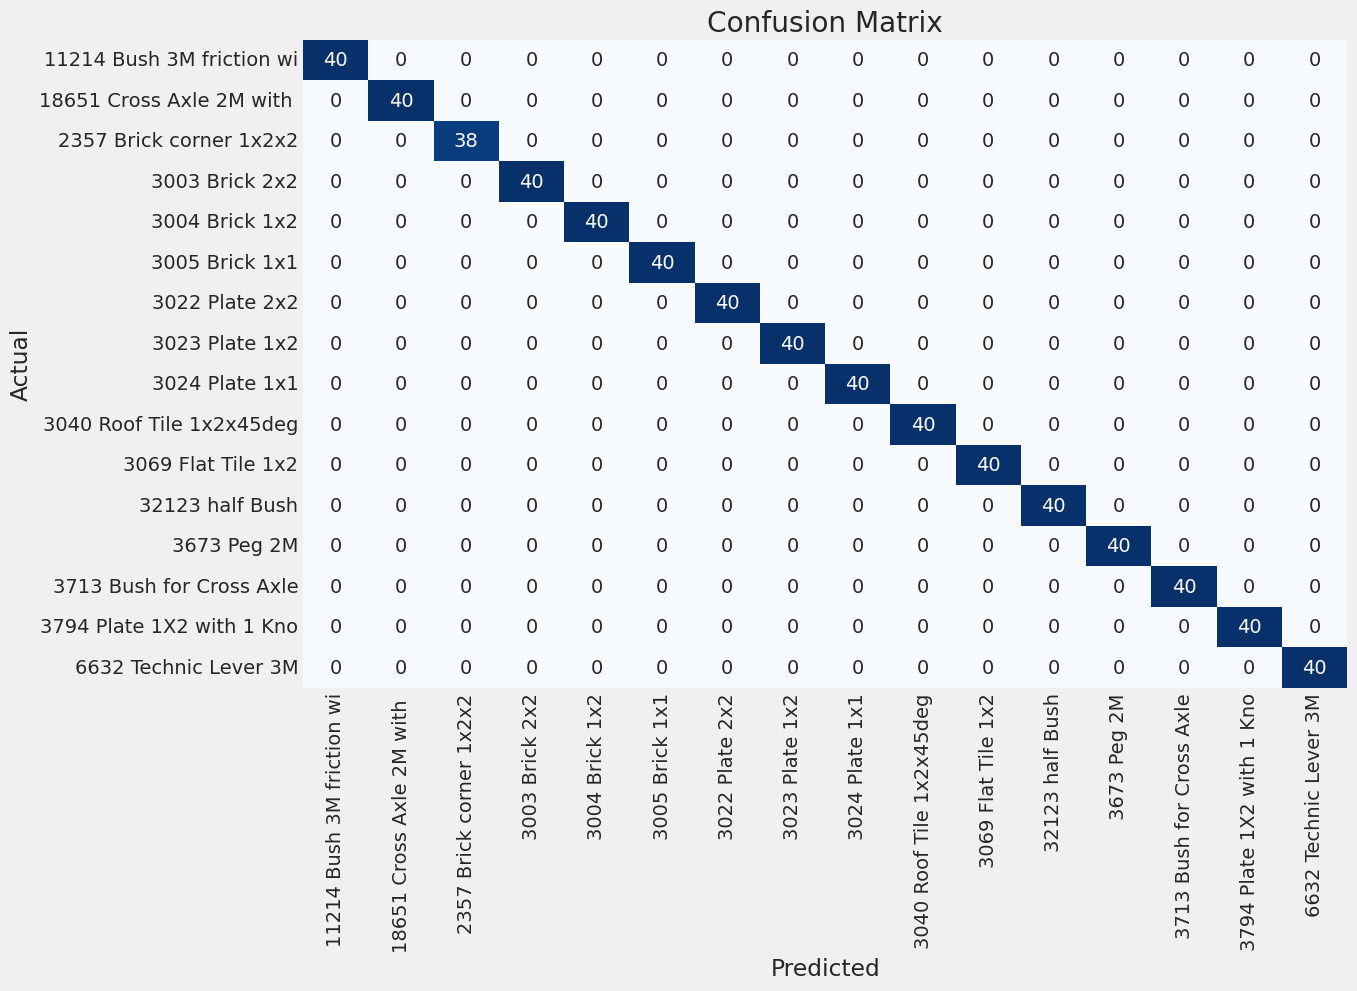

Classification Report:
----------------------
                            precision    recall  f1-score   support

11214 Bush 3M friction wi     1.0000    1.0000    1.0000        40
18651 Cross Axle 2M with      1.0000    1.0000    1.0000        40
  2357 Brick corner 1x2x2     1.0000    1.0000    1.0000        38
           3003 Brick 2x2     1.0000    1.0000    1.0000        40
           3004 Brick 1x2     1.0000    1.0000    1.0000        40
           3005 Brick 1x1     1.0000    1.0000    1.0000        40
           3022 Plate 2x2     1.0000    1.0000    1.0000        40
           3023 Plate 1x2     1.0000    1.0000    1.0000        40
           3024 Plate 1x1     1.0000    1.0000    1.0000        40
 3040 Roof Tile 1x2x45deg     1.0000    1.0000    1.0000        40
       3069 Flat Tile 1x2     1.0000    1.0000    1.0000        40
          32123 half Bush     1.0000    1.0000    1.0000        40
              3673 Peg 2M     1.0000    1.0000    1.0000        40
 3713 Bush for

In [18]:
def predictor(test_gen):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_gen)

## Si hay menos de 50 clasificaciones incorrectas, imprime los archivos mal clasificados.
Esta función, print_errors, verifica la lista de errores. Si no hay errores, muestra un mensaje que indica que no hubo errores en la predicción del conjunto de pruebas. Si hay errores, primero verifica si hay más de 50 clasificaciones incorrectas. Si no hay más de 50, muestra una lista de archivos que fueron clasificados incorrectamente junto con su predicción correspondiente. Utiliza la función print_in_color para resaltar los mensajes importantes.

In [19]:
def print_errors(error_list):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set')
    else:
        if len(error_list)>50:
            print_in_color('There were over 50 misclassifications, the error list will not be printed')
        else:
            print ('Below is a list of test files that were miss classified \n')
            print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))
            for i in range(len(error_list)):
                fpath=error_list[i]
                split=fpath.split('/')
                f=split[4]+ '-' + split[5]
                print(f'{f:^30s}{error_pred_list[i]:^30s}')

## Grabar el modelo
Este fragmento de código guarda un modelo entrenado en un directorio específico. Toma argumentos como el tema del modelo (subject), la cantidad de clases (classes), el tamaño de la imagen (img_size), el puntaje F1 (f1score) y el directorio de trabajo (working_dir). Utiliza esta información para generar un nombre único para el modelo guardado y lo guarda en la ubicación especificada. Finalmente, imprime un mensaje indicando la ubicación del modelo guardado.

In [20]:
def save_model(subject, classes, img_size, f1score, working_dir):
    name=subject + '-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
    save_id=f'{name}-{f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg= f'model was saved as {model_save_loc}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

Este código guarda el modelo bajo el tema 'legos' en una carpeta específica llamada 'c:\temp\cards'. Utiliza información previamente definida sobre las clases, el tamaño de la imagen y el puntaje F1 para nombrar y guardar el modelo en ese directorio.

In [21]:
working_dir=r'/content' # VERSION GOOGLE-COLAB
# working_dir=r'c:\temp\cards' # VERSION LOCAL
subject='legos'
save_model(subject, classes, img_size, f1score, working_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as /content/legos-16-(128 X 128)-100.00.h5



In [25]:
from google.colab import files

# Ruta local del modelo en Colab
model_path_colab = '/content/legos-16-(128 X 128)-100.00.h5'

# Descargar el modelo al entorno local
files.download(model_path_colab)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Creditos: https://www.kaggle.com/code/gpiosenka/lego-block-classification-f1-score-99-4